## Settings

In [0]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import svm

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_classification

In [0]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [0]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [0]:
# This notebook is written using the COLAB software in google drive
# To read data within a drive folder Google needs to be authorized
# This needs to be done every time the notebook is opened
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Functions

In [0]:
def reports(modelname, xtrain, xtest, ytrain, ytrain_pred, ytest, ytest_pred):
  '''
  Print the classification report and confusion matrix for both train and test
  '''
  print("{0} Train Accuracy Score: {1}".format(modelname, (ytrain == ytrain_pred).mean()))
  print("\n{0} Train Confusion Matrix".format(modelname))
  print(metrics.confusion_matrix(ytrain, ytrain_pred))
  print("\n{0} Train Classification Report".format(modelname))
  print(metrics.classification_report(ytrain, ytrain_pred))
  print('-'*53 + '\n')
  print("{0} Test Accuracy Score: {1}".format(modelname, (ytest == ytest_pred).mean()))
  print("\n{0} Test Confusion Matrix".format(modelname))
  print(metrics.confusion_matrix(ytest, ytest_pred))
  print("\n{0} Test Classification Report".format(modelname))
  print(metrics.classification_report(ytest, ytest_pred))
  
def svm_feature_importance_plot(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

# Load the Data

Data comes from the UCI Machine Learning Repository. It has been downloaded and placed into Google Drive for accessibilty

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [0]:
red = pd.read_csv('/content/gdrive/Team Drives/ML Project Team/wine/winequality-red.csv', sep=';')

In [0]:
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [0]:
# An example data point
red.iloc[0]

fixed acidity            7.4000
volatile acidity         0.7000
citric acid              0.0000
residual sugar           1.9000
chlorides                0.0760
free sulfur dioxide     11.0000
total sulfur dioxide    34.0000
density                  0.9978
pH                       3.5100
sulphates                0.5600
alcohol                  9.4000
quality                  5.0000
Name: 0, dtype: float64

In [0]:
red.shape

(1599, 12)

# Data Exploration

What does the data look like? It is important to look at the features themselves before diving into an ML task. Here we look at the distribution of classes and separation of features for insights on what model and transformations will be useful.

## Response

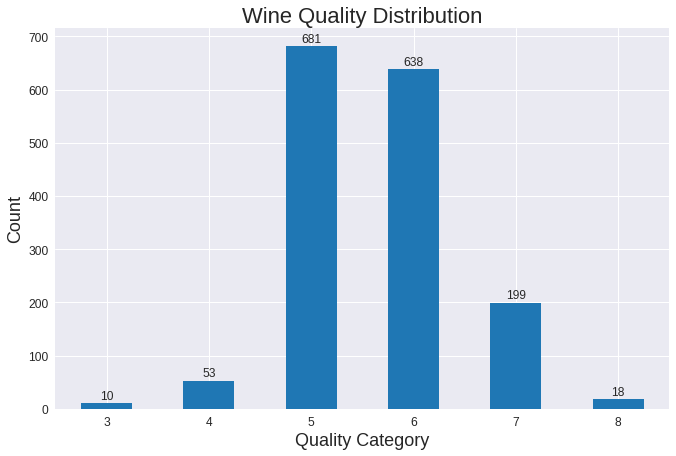

In [0]:
t = red.quality.value_counts().sort_index()
ax = t.plot.bar(figsize=(11,7), color='tab:blue')

plt.xticks(rotation=0)
plt.title('Wine Quality Distribution')
plt.xlabel('Quality Category')
plt.ylabel('Count')

for i, v in enumerate(t):
    ax.text(i, v+3, v, ha='center', va='bottom')

## Predictors

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa66ef58518>,
      dtype=object)

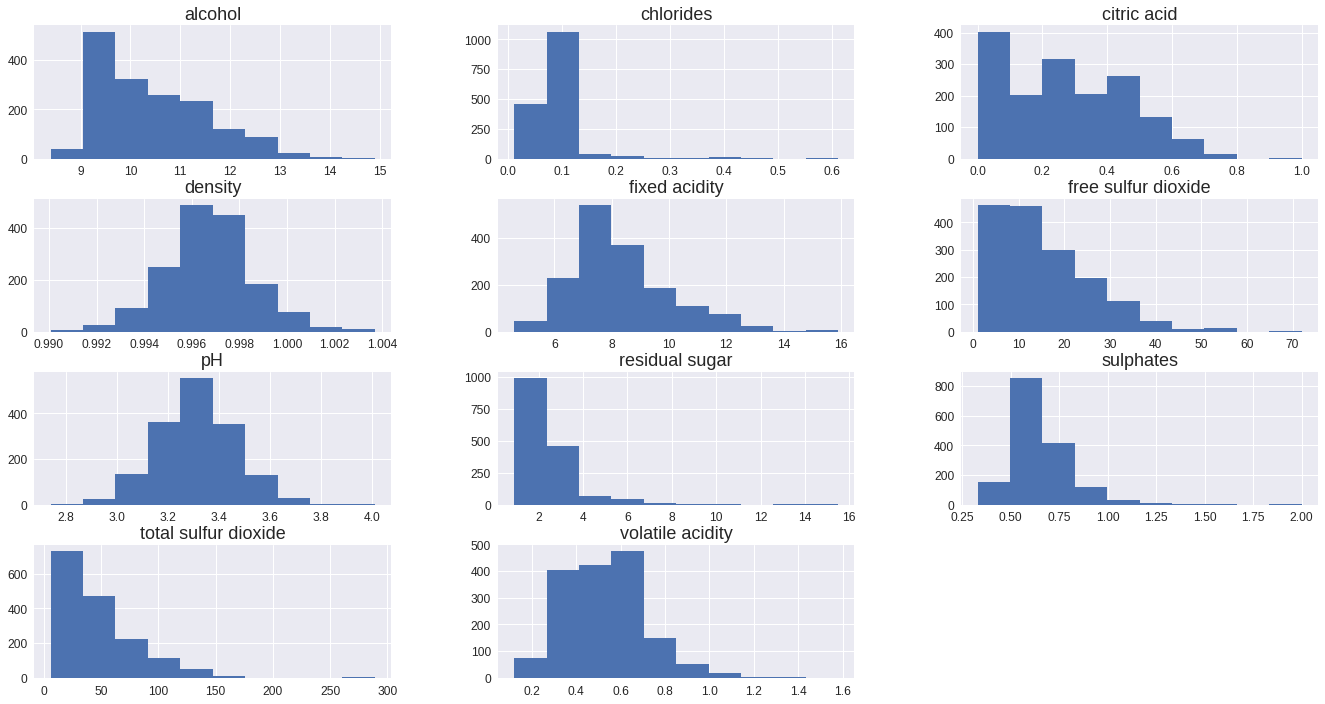

In [0]:
plt.rc('axes', titlesize=MEDIUM_SIZE)
red.drop(columns='quality').hist(figsize=(23,12))

## Correlation & Multicolinearity

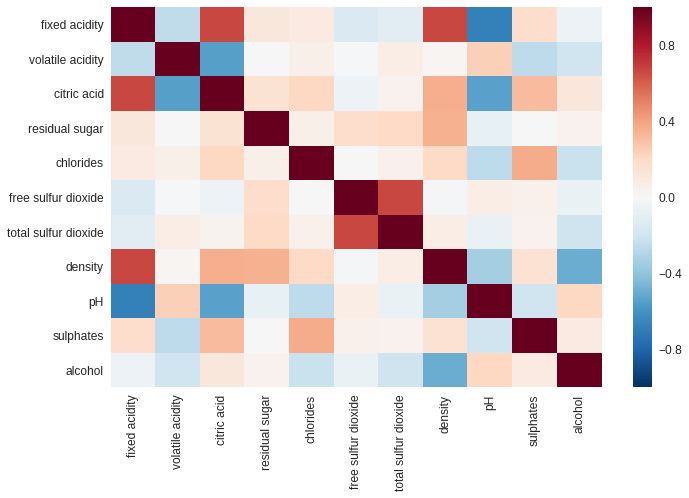

In [0]:
corr = red.drop(columns='quality').corr()

mask = np.zeros_like(corr, dtype=np.bool)

fig, ax = plt.subplots(figsize=(11,7))
sns.heatmap(corr, ax=ax)

In [0]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
vif_df = red.copy()
vif_df.columns = [c.replace(" ", "_") for c in vif_df.columns]

#gather features
features = "+".join(vif_df.drop(columns='quality').columns)

# get y and X dataframes based on this regression:
y2, X2 = dmatrices('quality ~' + features, vif_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns

vif.iloc[1:11,:]

,VIF Factor,features
1,7.767512,fixed_acidity
2,1.789390,volatile_acidity
3,3.128022,citric_acid
4,1.702588,residual_sugar
5,1.481932,chlorides
6,1.963019,free_sulfur_dioxide
7,2.186813,total_sulfur_dioxide
8,6.343760,density
9,3.329732,pH
10,1.429434,sulphates


# Data Transformation

Some of the variables are more seperable than others. It will be hard for a linear, logistic, or SVM model to separate between these classes.

We tried a few different data transformations:
  - Unbalanced, raw dataset 
  - Dropping and rebalancing the classes
  - Combining classes

## Unbalanced dataset

In [0]:
y = red['quality']
X = red.drop(columns='quality')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Balanced dataset with dropped classes

Here we drop classes 3 & 8 because there are so few datapoints, then rebalance the training set with the SMOTE function to create synthetic data.

In [0]:
red_drop = red[~red.quality.isin([3,8])]

y_drop = red_drop['quality']
X_drop = red_drop.drop(columns='quality')
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y_drop, test_size=0.20, random_state=42)

sm = SMOTE(random_state=42, sampling_strategy={4:277, 5:554, 6:509, 7:277})
X_train_bal, y_train_bal = sm.fit_resample(X_train_drop, y_train_drop)

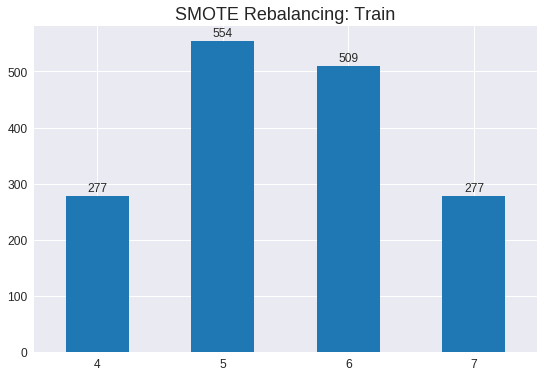

In [0]:
t = pd.Series(y_train_bal).value_counts().sort_index()
ax = t.plot.bar(figsize=(9,6), color='tab:blue')

plt.xticks(rotation=0)
plt.title('SMOTE Rebalancing: Train')

for i, v in enumerate(t):
    ax.text(i, v+3, v, ha='center', va='bottom')

## Combining Classes

A second way of addressesing the imbalanced classes is to change the target output. Who cares about the difference between a 7 and an 8 anyway? We just want to know good or bad. Here we combine 3, 4, 5 into a 'bad' class and 6, 7, 8 into a 'good' class.

In [0]:
y_train_bin = pd.Series([y >= 6 for y in y_train])
y_test_bin = pd.Series([y >= 6 for y in y_test])

In [0]:
 y_train_bin.value_counts()

True     676
False    603
dtype: int64

Text(0.5,1,'Binning Classes: Train')

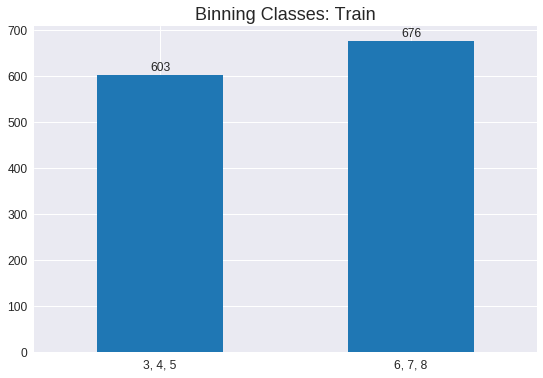

In [0]:
fig, ax = plt.subplots(figsize=(9,6))
t = y_train_bin.value_counts().sort_index()
t.plot.bar(color='tab:blue', ax=ax)
ax.set_xticklabels(['3, 4, 5', '6, 7, 8'],rotation=0)
for i, v in enumerate(t):
    ax.text(i, v+3, v, ha='center', va='bottom')
ax.set_title('Binning Classes: Train')

# Model Building

In [0]:
# keep track of final models & important scores
models = {}

## Scaling the Dataset

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [0]:
scaler_bal = StandardScaler()
scaler_bal.fit(X_train_bal)

X_train_bal_scaled = pd.DataFrame(scaler.transform(X_train_bal), columns=X.columns)
X_test_bal_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [0]:
X_train_scaled.shape

(1279, 11)

In [0]:
y_train_bal.shape

(1617,)

## SVM - Scott

### Unbalanced

#### Grid Search

The first model to train is the SVM with linear kernel. We used grid search to tune the C hyperparamter. When training the model we ran many more instances of C, but as this notebook needed to be run many times we limit the number here for expidency's sake.

In [0]:
parameters = {'C': [0.2, 0.4, 0.6, 0.8, 1.0]}
svc = svm.SVC(kernel='linear')

grid_svc = GridSearchCV(svc, parameters, cv=5, refit=True, n_jobs=-1, verbose=1, return_train_score=True)
grid_svc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.2, 0.4, 0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [0]:
grid_svc.best_params_

{'C': 0.4}

In [0]:
models['SVM'] = {
    'unbalanced': {
        'model': grid_svc.best_estimator_,
        'params': grid_svc.best_params_
    }
}

#### Predictions

In [0]:
y_train_pred_svc = grid_svc.predict(X_train_scaled)
y_test_pred_svc = grid_svc.predict(X_test_scaled)

In [0]:
reports("SVM Unbalanced",
    X_train_scaled, X_test_scaled, 
    y_train, y_train_pred_svc, 
    y_test, y_test_pred_svc)

SVM Unbalanced Train Accuracy Score: 0.5934323690383112

SVM Unbalanced Train Confusion Matrix
[[  0   0   8   1   0   0]
 [  0   0  28  15   0   0]
 [  0   0 432 119   0   0]
 [  0   0 179 327   0   0]
 [  0   0  11 146   0   0]
 [  0   0   0  13   0   0]]

SVM Unbalanced Train Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        43
           5       0.66      0.78      0.71       551
           6       0.53      0.65      0.58       506
           7       0.00      0.00      0.00       157
           8       0.00      0.00      0.00        13

   micro avg       0.59      0.59      0.59      1279
   macro avg       0.20      0.24      0.22      1279
weighted avg       0.49      0.59      0.54      1279

-----------------------------------------------------

SVM Unbalanced Test Accuracy Score: 0.565625

SVM Unbalanced Test Confusion Matrix
[[  0   0   1   0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_test_pred_svc)).to_csv()

',0,1,2,3,4,5\n0,0,0,1,0,0,0\n1,0,0,9,1,0,0\n2,0,0,102,28,0,0\n3,0,0,53,79,0,0\n4,0,0,3,39,0,0\n5,0,0,0,5,0,0\n'

In [0]:
models['SVM']['unbalanced']['accuracy'] = {
    'train': (y_train == y_train_pred_svc).mean(),
    'test': (y_test == y_test_pred_svc).mean(),
}

#### Feature Importance

The weights obtained from svm.coef_ represent the vector coordinates which are orthogonal to the hyperplane and their direction indicates the predicted class. With a multiclass problem, there are more coordinates than just the one set, there are `n_class * (n_class-1) / 2`, which for the unbalanced data is 15. To get an idea of overall feature importance we take the mean of each coefficient across the predictor.

The positive and negative directions mean less with a multiclass problem, as we're not sure which class they are predicting at any given moment. Positive could mean one class on the first split and then a different class on the second split. But overall size is important. Below we see that alcohol is the most important feature followed by volitile acidity, sulphates, pH, and chlorides.

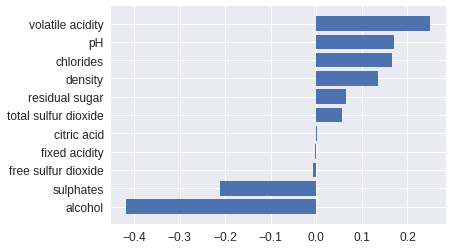

In [0]:
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

svm_feature_importance_plot(
    pd.DataFrame(grid_svc.best_estimator_.coef_).apply('mean'), 
    X.columns)

### Balanced

#### Grid Search

In [0]:
params_svc_bal = {'C': [0.2, 0.4, 0.6, 0.8, 1.0]}
svc_bal = svm.SVC(kernel='linear')

grid_svc_bal = GridSearchCV(svc_bal, params_svc_bal, cv=5, refit=True, n_jobs=-1, verbose=1, return_train_score=True)
grid_svc_bal.fit(X_train_bal_scaled, y_train_bal)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.2, 0.4, 0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [0]:
grid_svc_bal.best_params_

{'C': 0.6}

#### Predictions

In [0]:
y_train_bal_pred_svc = grid_svc_bal.predict(X_train_bal_scaled)
y_test_bal_pred_svc = grid_svc_bal.predict(X_test_bal_scaled)

In [0]:
reports("SVM Balanced",
    X_train_bal_scaled, X_test_bal_scaled, 
    y_train_bal, y_train_bal_pred_svc, 
    y_test, y_test_bal_pred_svc)

SVM Balanced Train Accuracy Score: 0.5763760049474336

SVM Balanced Train Confusion Matrix
[[126 116  32   3]
 [ 38 412  87  17]
 [ 34 166 226  83]
 [  8  16  85 168]]

SVM Balanced Train Classification Report
              precision    recall  f1-score   support

           4       0.61      0.45      0.52       277
           5       0.58      0.74      0.65       554
           6       0.53      0.44      0.48       509
           7       0.62      0.61      0.61       277

   micro avg       0.58      0.58      0.58      1617
   macro avg       0.58      0.56      0.57      1617
weighted avg       0.58      0.58      0.57      1617

-----------------------------------------------------

SVM Balanced Test Accuracy Score: 0.53125

SVM Balanced Test Confusion Matrix
[[ 0  1  0  0  0  0]
 [ 0  4  5  1  0  0]
 [ 0 11 97 18  4  0]
 [ 0  5 52 48 27  0]
 [ 0  1  3 17 21  0]
 [ 0  0  0  0  5  0]]

SVM Balanced Test Classification Report
              precision    recall  f1-score   support


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
models['SVM']['balanced'] = {
    'model': grid_svc_bal.best_estimator_,
    'params': grid_svc_bal.best_params_,
    'accuracy': {
        'train': (y_train_bal == y_train_bal_pred_svc).mean(),
        'test': (y_test == y_test_bal_pred_svc).mean()
    }
}

#### Feature Importance

Similar features are important to the balanced dataset as they were in the unbalanced dataset. Density is a new important one.

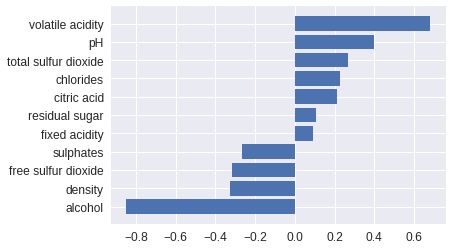

In [0]:
svm_feature_importance_plot(
    pd.DataFrame(grid_svc_bal.best_estimator_.coef_).apply('mean'), 
    X.columns)

### Combined Classes

#### Grid Search

In [0]:
params_svc_bin = {'C': [0.2, 0.4, 0.6, 0.8, 1.0]}
svc_bin = svm.SVC(kernel='linear')

grid_svc_bin = GridSearchCV(svc_bin, params_svc_bin, cv=5, refit=True, n_jobs=-1, verbose=1, return_train_score=True)
grid_svc_bin.fit(X_train_scaled, y_train_bin)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.2, 0.4, 0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [0]:
grid_svc_bin.best_params_

{'C': 0.2}

#### Predictions

In [0]:
y_train_bin_pred_svc = grid_svc_bin.predict(X_train_scaled)
y_test_bin_pred_svc = grid_svc_bin.predict(X_test_scaled)

In [0]:
reports("SVM Combined",
    X_train_scaled, X_test_scaled, 
    y_train_bin, y_train_bin_pred_svc, 
    y_test_bin, y_test_bin_pred_svc)

SVM Combined Train Accuracy Score: 0.746677091477717

SVM Combined Train Confusion Matrix
[[470 133]
 [191 485]]

SVM Combined Train Classification Report
              precision    recall  f1-score   support

       False       0.71      0.78      0.74       603
        True       0.78      0.72      0.75       676

   micro avg       0.75      0.75      0.75      1279
   macro avg       0.75      0.75      0.75      1279
weighted avg       0.75      0.75      0.75      1279

-----------------------------------------------------

SVM Combined Test Accuracy Score: 0.728125

SVM Combined Test Confusion Matrix
[[110  31]
 [ 56 123]]

SVM Combined Test Classification Report
              precision    recall  f1-score   support

       False       0.66      0.78      0.72       141
        True       0.80      0.69      0.74       179

   micro avg       0.73      0.73      0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.74      0.73      0.73     

In [0]:
models['SVM']['combined'] = {
    'model': grid_svc_bin.best_estimator_,
    'params': grid_svc_bin.best_params_,
    'accuracy': {
        'train': (y_train_bin == y_train_bin_pred_svc).mean(),
        'test': (y_test_bin == y_test_bin_pred_svc).mean()
    }
}

#### Feature Importance

Alcohol is much more important in the combined classes data than it was in either of the first two, completely dominating this set.

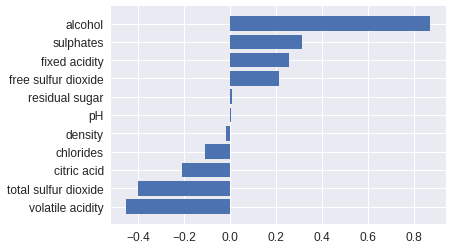

In [0]:
svm_feature_importance_plot(
    pd.DataFrame(grid_svc_bin.best_estimator_.coef_).apply('mean'), 
    X.columns)

## AdaBoost - Shree

### Unbalanced

#### Grid Search 1

AdaBoost Classifier along with GridSearchCV tool

Starting with a dictionary of a few parameters, then continue to tune:
  
    n_estimators: 100, 200, 300  
    learning_rate: 0.5, 1, 1.5

In [0]:
param_grid = {
  'n_estimators' : [100,200,300],
  'learning_rate': [0.5,1,1.5]}

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)
ada_Grid1 = GridSearchCV(ada_clf, param_grid, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
# Fit the model:
ada_Grid1.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300], 'learning_rate': [0.5, 1, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid1.best_params_

{'learning_rate': 1, 'n_estimators': 100}

#### Grid Search 2

The best estimator gave a learning rate of 1, which was the middle parameter
chosen, and 100 estimators, which was the least number of parameters.   
So on the second round tune this a bit finer grain

In [0]:
param_grid2 = {
  'n_estimators' : [50, 100, 150],
  'learning_rate': [0.8, 1, 1.2]}

ada_clf2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)
ada_Grid2 = GridSearchCV(ada_clf2, param_grid2, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid2.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'learning_rate': [0.8, 1, 1.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid2.best_params_

{'learning_rate': 1, 'n_estimators': 50}

#### Grid Search 3

The second iteration gave the learning parameter of 1 again and again the least number of estimators.  
Tune again using learning rate of 1 and more estimators focused around 50.

In [0]:
param_grid3 = {
  'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80],
  'learning_rate': [1]}

ada_clf3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)
ada_Grid3 = GridSearchCV(ada_clf3, param_grid3, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid3.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80], 'learning_rate': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid3.best_params_

{'learning_rate': 1, 'n_estimators': 10}

We don't want to go below 10 estimators so we will stop here and base predictions off of the third grid search result.


#### Predictions

In [0]:
y_train_pred_ada = ada_Grid3.predict(X_train_scaled)
y_test_pred_ada = ada_Grid3.predict(X_test_scaled)

In [0]:
reports("Unbalanced ADA",
    X_train_scaled, X_test_scaled, 
    y_train, y_train_pred_ada, 
    y_test, y_test_pred_ada)

Unbalanced ADA Train Accuracy Score: 0.5582486317435497

Unbalanced ADA Train Confusion Matrix
[[  1   3   5   0   0   0]
 [  1   2  26  14   0   0]
 [  5   2 462  82   0   0]
 [  0   1 256 249   0   0]
 [  0   0  30 127   0   0]
 [  0   0   2  11   0   0]]

Unbalanced ADA Train Classification Report
              precision    recall  f1-score   support

           3       0.14      0.11      0.12         9
           4       0.25      0.05      0.08        43
           5       0.59      0.84      0.69       551
           6       0.52      0.49      0.50       506
           7       0.00      0.00      0.00       157
           8       0.00      0.00      0.00        13

   micro avg       0.56      0.56      0.56      1279
   macro avg       0.25      0.25      0.23      1279
weighted avg       0.47      0.56      0.50      1279

-----------------------------------------------------

Unbalanced ADA Test Accuracy Score: 0.528125

Unbalanced ADA Test Confusion Matrix
[[  0   0   1   0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
models['ADA'] = {
    'unbalanced': {
      'model': ada_Grid3.best_estimator_,
      'params': ada_Grid3.best_params_,
      'accuracy': {
          'train': (y_train == y_train_pred_ada).mean(),
          'test': (y_test == y_test_pred_ada).mean()
      }
    }
}

#### Feature Importance

One nice thinga about tree-based methods is that you can get feature importances. This will tell us how much each predictor contributed to the overall model. With boosted trees you lose the easy interpretibility of a single decision tree, but you can gain some of that back by looking at feature importances.

In [0]:
importances = ada_Grid3.best_estimator_.feature_importances_
stds = np.std([tree.feature_importances_ for tree in ada_Grid3.best_estimator_.estimators_], axis=0)

fi_df_ada = pd.DataFrame(
    data={'importance': pd.Series(importances), 
          'std': pd.Series(stds),
          'feature': X.columns
         }
).sort_values('importance', ascending=False)
fi_df_ada

,feature,importance,std
4,chlorides,0.4,0.489898
9,sulphates,0.4,0.489898
1,volatile acidity,0.1,0.300000
10,alcohol,0.1,0.300000
0,fixed acidity,0.0,0.000000
2,citric acid,0.0,0.000000
3,residual sugar,0.0,0.000000
5,free sulfur dioxide,0.0,0.000000
6,total sulfur dioxide,0.0,0.000000
7,density,0.0,0.000000


Text(0,0.5,'Importance')

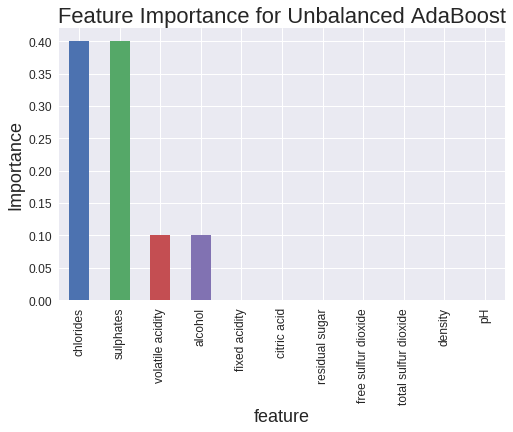

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
fi_df_ada.plot.bar(x='feature', y='importance', ax=ax, legend=False)
ax.set_title('Feature Importance for Unbalanced AdaBoost')
ax.set_ylabel('Importance')

Only four features end up having any bearing on the predicted classes for the unbalanced dataset when using AdaBoost: 
  - chlorides
  - sulphates
  - volatile acidity
  - alcohol

### Balanced

#### Grid Search 1

Repeat the parameter tuning for the balanced dataset. Hopefully with a balanced dataset the grid search will return more sensible parameters.

In [0]:
param_grid_bal1 = {
  'n_estimators' : [100, 200, 300],
  'learning_rate': [0.2, 0.6, 1.0, 1.2]}

ada_clf_bal1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)
ada_Grid_bal1 = GridSearchCV(ada_clf_bal1, param_grid_bal1, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid_bal1.fit(X_train_bal_scaled, y_train_bal)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   26.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300], 'learning_rate': [0.2, 0.6, 1.0, 1.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid_bal1.best_params_

{'learning_rate': 0.2, 'n_estimators': 100}

#### Grid Search 2

In the first search, the hyperparameters returned were the lowest learning rate and the lowest number of estimators. Repeat the grid with finer control round these rates.

In [0]:
param_grid_bal2 = {
  'n_estimators' : [40, 60, 80, 100, 120],
  'learning_rate': [0.1, 0.2, 0.3]}

ada_clf_bal2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)
ada_Grid_bal2 = GridSearchCV(ada_clf_bal2, param_grid_bal2, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid_bal2.fit(X_train_bal_scaled, y_train_bal)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  75 | elapsed:   12.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   13.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [40, 60, 80, 100, 120], 'learning_rate': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid_bal2.best_params_

{'learning_rate': 0.1, 'n_estimators': 80}

#### Grid Search 3

Again with the lowest learning rate but not the lowest number of estimators. This time tune only the learning rate

In [0]:
param_grid_bal3 = {
  'learning_rate': [0.06, 0.08, 0.10, 0.12, 0.14]
}

ada_clf_bal3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42, n_estimators=80)
ada_Grid_bal3 = GridSearchCV(ada_clf_bal3, param_grid_bal3, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid_bal3.fit(X_train_bal_scaled, y_train_bal)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=80, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.06, 0.08, 0.1, 0.12, 0.14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid_bal3.best_params_

{'learning_rate': 0.08}

A learning rate and number of estimators have been found for the balanced dataset.

    n_estimators = 80
    learning_rate = 0.08

#### Predictions

In [0]:
y_train_bal_pred_ada = ada_Grid_bal3.predict(X_train_bal_scaled)
y_test_bal_pred_ada = ada_Grid_bal3.predict(X_test_bal_scaled)

reports("Balanced ADA",
    X_train_bal_scaled, X_test_bal_scaled, 
    y_train_bal, y_train_bal_pred_ada, 
    y_test, y_test_bal_pred_ada)

Balanced ADA Train Accuracy Score: 0.5553494124922697

Balanced ADA Train Confusion Matrix
[[ 92 132  53   0]
 [ 27 381 144   2]
 [ 14 133 321  41]
 [  0   6 167 104]]

Balanced ADA Train Classification Report
              precision    recall  f1-score   support

           4       0.69      0.33      0.45       277
           5       0.58      0.69      0.63       554
           6       0.47      0.63      0.54       509
           7       0.71      0.38      0.49       277

   micro avg       0.56      0.56      0.56      1617
   macro avg       0.61      0.51      0.53      1617
weighted avg       0.59      0.56      0.55      1617

-----------------------------------------------------

Balanced ADA Test Accuracy Score: 0.565625

Balanced ADA Test Confusion Matrix
[[ 0  1  0  0  0  0]
 [ 0  5  5  0  0  0]
 [ 0  7 89 33  1  0]
 [ 0  6 38 76 12  0]
 [ 0  0  0 31 11  0]
 [ 0  0  0  3  2  0]]

Balanced ADA Test Classification Report
              precision    recall  f1-score   support

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
models['ADA']['balanced'] = {
    'model': ada_Grid_bal3.best_estimator_,
    'params': ada_Grid_bal3.best_params_,
    'accuracy': {
        'train': (y_train_bal == y_train_bal_pred_ada).mean(),
        'test': (y_test == y_test_bal_pred_ada).mean()
    }
}

#### Feature Importance

In [0]:
importances = ada_Grid_bal3.best_estimator_.feature_importances_
stds = np.std([tree.feature_importances_ for tree in ada_Grid_bal3.best_estimator_.estimators_], axis=0)

fi_df_ada_bal = pd.DataFrame(
    data={'importance': pd.Series(importances), 
          'std': pd.Series(stds),
          'feature': X.columns
         }
).sort_values('importance', ascending=False)
fi_df_ada_bal

,feature,importance,std
10,alcohol,0.3125,0.463512
1,volatile acidity,0.2875,0.452597
6,total sulfur dioxide,0.2000,0.400000
9,sulphates,0.1875,0.390312
3,residual sugar,0.0125,0.111102
0,fixed acidity,0.0000,0.000000
2,citric acid,0.0000,0.000000
4,chlorides,0.0000,0.000000
5,free sulfur dioxide,0.0000,0.000000
7,density,0.0000,0.000000


Text(0,0.5,'Importance')

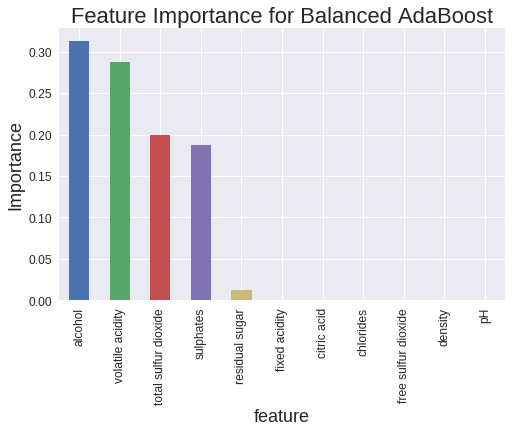

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
fi_df_ada_bal.plot.bar(x='feature', y='importance', ax=ax, legend=False)
ax.set_title('Feature Importance for Balanced AdaBoost')
ax.set_ylabel('Importance')

### Combined Classes

#### Grid Search 1

Finally, the last dataset for AdaBoost -- Combined Classes. Similar approach to hyperparameter tuning as the other models.

In [0]:
param_grid_bin1 = {
  'n_estimators' : [100, 200, 300],
  'learning_rate': [0.2, 0.4, 0.8, 1.0]}

ada_clf_bin1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)

ada_Grid_bin1 = GridSearchCV(ada_clf_bin1, param_grid_bin1, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid_bin1.fit(X_train_scaled, y_train_bin)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   20.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300], 'learning_rate': [0.2, 0.4, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid_bin1.best_params_

{'learning_rate': 0.2, 'n_estimators': 300}

#### Grid Search 2

Interestingly, the number of estimators is no longer the lowest possible input. So this time around we have to search on a higher ceiling of estimators and a lower threshold for learning rate

In [0]:
param_grid_bin2 = {
  'n_estimators' : [350, 400, 500],
  'learning_rate': [0.05, 0.10, 0.15]}

ada_clf_bin2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)
ada_Grid_bin2 = GridSearchCV(ada_clf_bin2, param_grid_bin2, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid_bin2.fit(X_train_scaled, y_train_bin)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [350, 400, 500], 'learning_rate': [0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid_bin2.best_params_

{'learning_rate': 0.15, 'n_estimators': 400}

#### Grid Search 3

A bit more tuning and we're just about done with AdaBoost

In [0]:
param_grid_bin3 = {
  'n_estimators' : [350, 400, 450],
  'learning_rate': [0.15, 0.18, 0.20]}

ada_clf_bin3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)
ada_Grid_bin3 = GridSearchCV(ada_clf_bin3, param_grid_bin3, cv = 5, refit=True, n_jobs=-1, verbose = 1)

In [0]:
ada_Grid_bin3.fit(X_train_scaled, y_train_bin)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [350, 400, 450], 'learning_rate': [0.15, 0.18, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
ada_Grid_bin3.best_params_

{'learning_rate': 0.18, 'n_estimators': 350}

We have our hyperparameters for AdaBoost Combined Classes

    n_estimators: 350
    learning_rate: 0.18

#### Predictions

In [0]:
# b) Use the best estimator from GridSearchCV to predict on test data.Use the.predict_proba()
# and the .predict() methods to get predicted probabilities as well as predicted classes.

y_train_bin_pred_ada = ada_Grid_bin3.predict(X_train_scaled)
y_test_bin_pred_ada = ada_Grid_bin3.predict(X_test_scaled)


reports("Combined AdaBoost",
    X_train_scaled, X_test_scaled, 
    y_train_bin, y_train_bin_pred_ada, 
    y_test_bin, y_test_bin_pred_ada)

Combined AdaBoost Train Accuracy Score: 0.8076622361219703

Combined AdaBoost Train Confusion Matrix
[[484 119]
 [127 549]]

Combined AdaBoost Train Classification Report
              precision    recall  f1-score   support

       False       0.79      0.80      0.80       603
        True       0.82      0.81      0.82       676

   micro avg       0.81      0.81      0.81      1279
   macro avg       0.81      0.81      0.81      1279
weighted avg       0.81      0.81      0.81      1279

-----------------------------------------------------

Combined AdaBoost Test Accuracy Score: 0.759375

Combined AdaBoost Test Confusion Matrix
[[109  32]
 [ 45 134]]

Combined AdaBoost Test Classification Report
              precision    recall  f1-score   support

       False       0.71      0.77      0.74       141
        True       0.81      0.75      0.78       179

   micro avg       0.76      0.76      0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg     

In [0]:
models['ADA']['combined'] = {
    'model': ada_Grid_bin3.best_estimator_,
    'params': ada_Grid_bin3.best_params_,
    'accuracy': {
        'train': (y_train_bin == y_train_bin_pred_ada).mean(),
        'test': (y_test_bin == y_test_bin_pred_ada).mean()
    }
}

#### Feature Importance

In [0]:
importances = ada_Grid_bin3.best_estimator_.feature_importances_
stds = np.std([tree.feature_importances_ for tree in ada_Grid_bin3.best_estimator_.estimators_], axis=0)

fi_ada_bin = pd.DataFrame(
    data={'importance': pd.Series(importances), 
          'std': pd.Series(stds),
          'feature': X.columns
         }
).sort_values('importance', ascending=False)
fi_ada_bin

,feature,importance,std
4,chlorides,0.165714,0.371824
10,alcohol,0.165714,0.371824
9,sulphates,0.128571,0.334725
6,total sulfur dioxide,0.105714,0.307472
7,density,0.091429,0.288218
3,residual sugar,0.088571,0.284124
2,citric acid,0.065714,0.247782
0,fixed acidity,0.062857,0.242706
1,volatile acidity,0.045714,0.208865
8,pH,0.045714,0.208865


Text(0,0.5,'Importance')

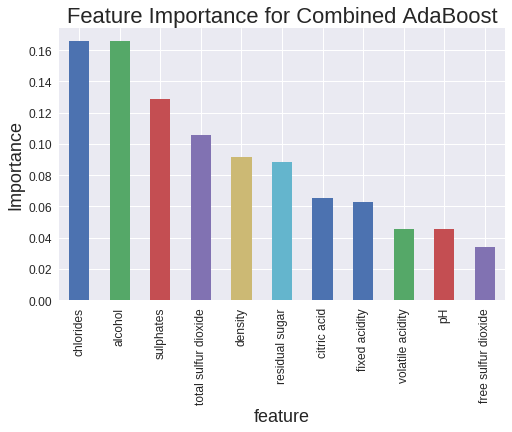

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
fi_ada_bin.plot.bar(x='feature', y='importance', ax=ax, legend=False)
ax.set_title('Feature Importance for Combined AdaBoost')
ax.set_ylabel('Importance')

The features that came up as important in the other two datasets continue to be important here, but noteable all the features are included when predicting a binary variable.

## Random Forest 


### Unbalanced

#### Grid Search 1

RandomForest Classifier with GridSearchCV

parameters:  

    n_estimators: [500, 750, 1000]  
    max_features: [2, 4, 6]
    max_depth: [10, 50, 100]


In [0]:
param_grid_rdf1 = {
    'n_estimators': [500, 750, 1000],
    'max_features': [2, 4, 6],
    'max_depth': [10, 50, 100]
}

rdf1 = RandomForestClassifier(random_state=42)
grid_search_rdf1 = GridSearchCV(rdf1, param_grid_rdf1, cv=5, refit=True, n_jobs=-1, verbose=1)
grid_search_rdf1.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [500, 750, 1000], 'max_features': [2, 4, 6], 'max_depth': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
grid_search_rdf1.best_params_

{'max_depth': 50, 'max_features': 2, 'n_estimators': 750}

#### Grid Search 2

Grid Search picked up the max number of n_estimators and and min number of max_features. Retune centered around these variables. 

    n_estimators: [700, 750, 800]  
    max_features: 2
    max_depth: [40, 50, 60]

In [0]:
param_grid_rdf2 = {
   'n_estimators': [700, 750, 800],
   'max_depth': [40, 50, 60]
}

rdf2 = RandomForestClassifier(random_state=42, max_features=2)
grid_search_rdf2 = GridSearchCV(rdf2, param_grid_rdf2, cv=5, refit=True, n_jobs=-1, verbose=1)
grid_search_rdf2.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   58.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [700, 750, 800], 'max_depth': [40, 50, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
grid_search_rdf2.best_params_

{'max_depth': 40, 'n_estimators': 800}

I don't think a third round of training is needed. These parameters are just going to memorize the training data anyway.

#### Predictions 1

In [0]:
y_train_pred_rdf = grid_search_rdf2.predict(X_train_scaled)
y_test_pred_rdf = grid_search_rdf2.predict(X_test_scaled)

In [0]:
reports("Unbalanced RandomForest",
    X_train_scaled, X_test_scaled, 
    y_train, y_train_pred_rdf, 
    y_test, y_test_pred_rdf)

Unbalanced RandomForest Train Accuracy Score: 1.0

Unbalanced RandomForest Train Confusion Matrix
[[  9   0   0   0   0   0]
 [  0  43   0   0   0   0]
 [  0   0 551   0   0   0]
 [  0   0   0 506   0   0]
 [  0   0   0   0 157   0]
 [  0   0   0   0   0  13]]

Unbalanced RandomForest Train Classification Report
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00       551
           6       1.00      1.00      1.00       506
           7       1.00      1.00      1.00       157
           8       1.00      1.00      1.00        13

   micro avg       1.00      1.00      1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

-----------------------------------------------------

Unbalanced RandomForest Test Accuracy Score: 0.671875

Unbalanced RandomForest Test Conf

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Wow that is a nastily overfit tree. The model just memorized the training data! Still, it did better on the test set than any other model run so far, so maybe dramatic overfitting isn't that terrible of an idea.

However it's probably a good idea to limit the depth and try again.

#### Grid Search 3

Doing a third round of tuning after all, this time with a limited number of estimators and no depth pruning.

In [0]:
param_grid_rdf3 = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [1, 2, 3, 4]
}

rdf3 = RandomForestClassifier(random_state=42)
grid_search_rdf3 = GridSearchCV(rdf3, param_grid_rdf3, cv=5, refit=True, n_jobs=-1, verbose=1)
grid_search_rdf3.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_features': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
grid_search_rdf3.best_params_

{'max_features': 1, 'n_estimators': 400}

In [0]:
y_train_pred_rdf = grid_search_rdf3.predict(X_train_scaled)
y_test_pred_rdf = grid_search_rdf3.predict(X_test_scaled)

In [0]:
reports("Unbalanced RandomForest",
    X_train_scaled, X_test_scaled, 
    y_train, y_train_pred_rdf, 
    y_test, y_test_pred_rdf)

Unbalanced RandomForest Train Accuracy Score: 1.0

Unbalanced RandomForest Train Confusion Matrix
[[  9   0   0   0   0   0]
 [  0  43   0   0   0   0]
 [  0   0 551   0   0   0]
 [  0   0   0 506   0   0]
 [  0   0   0   0 157   0]
 [  0   0   0   0   0  13]]

Unbalanced RandomForest Train Classification Report
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00       551
           6       1.00      1.00      1.00       506
           7       1.00      1.00      1.00       157
           8       1.00      1.00      1.00        13

   micro avg       1.00      1.00      1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

-----------------------------------------------------

Unbalanced RandomForest Test Accuracy Score: 0.66875

Unbalanced RandomForest Test Confu

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Still way too much overfitting. It seems like GridSearch latches onto the highest number of estimators. Can we get something better with manual tuning?

#### Manual Tuning

In [0]:
rdf = RandomForestClassifier(random_state=42, n_estimators=100, max_features=2, max_depth=10)
rdf.fit(X_train_bal_scaled, y_train_bal)

y_train_pred_rdf = rdf.predict(X_train_scaled)
y_test_pred_rdf = rdf.predict(X_test_scaled)

reports("Unbalanced RandomForest",
    X_train_scaled, X_test_scaled, 
    y_train, y_train_pred_rdf,
    y_test, y_test_pred_rdf)

Unbalanced RandomForest Train Accuracy Score: 0.8889757623143081

Unbalanced RandomForest Train Confusion Matrix
[[  0   2   6   1   0   0]
 [  0  37   5   1   0   0]
 [  0   2 519  27   3   0]
 [  0   2  43 452   9   0]
 [  0   0   6  22 129   0]
 [  0   0   0   8   5   0]]

Unbalanced RandomForest Train Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.86      0.86      0.86        43
           5       0.90      0.94      0.92       551
           6       0.88      0.89      0.89       506
           7       0.88      0.82      0.85       157
           8       0.00      0.00      0.00        13

   micro avg       0.89      0.89      0.89      1279
   macro avg       0.59      0.59      0.59      1279
weighted avg       0.87      0.89      0.88      1279

-----------------------------------------------------

Unbalanced RandomForest Test Accuracy Score: 0.871875

Unbalanced RandomF

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


WOW! So much better on the overfitting and a boosted accuracy score.

In [0]:
models['RDF'] = {
    'unbalanced': {
      'model': rdf,
      'params': {'n_estimators':100, 'max_features':2},
      'accuracy': {
          'train': (y_train == y_train_pred_rdf).mean(),
          'test': (y_test == y_test_pred_rdf).mean()
      }
    }
}

#### Feature Importance

In [0]:
importances = rdf.feature_importances_
fi_rdf = pd.DataFrame(
    data={'importance': pd.Series(importances), 
          'feature': X.columns
         }
).sort_values('importance', ascending=False)
fi_rdf

,feature,importance
10,alcohol,0.147349
6,total sulfur dioxide,0.114992
9,sulphates,0.110124
1,volatile acidity,0.108191
7,density,0.087873
0,fixed acidity,0.076790
5,free sulfur dioxide,0.074832
2,citric acid,0.071463
4,chlorides,0.070946
8,pH,0.069608


Text(0,0.5,'Importance')

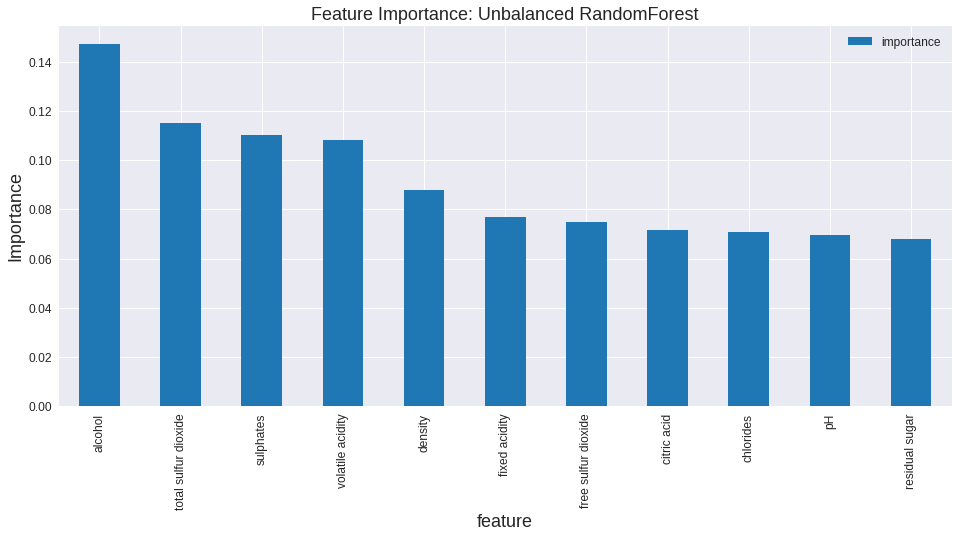

In [0]:
plt.rc('axes', titlesize=MEDIUM_SIZE)
fig, ax = plt.subplots(figsize=(16, 7))
fi_rdf.plot.bar(x='feature', y='importance', ax=ax, color='tab:blue')
ax.set_title('Feature Importance: Unbalanced RandomForest')
ax.set_ylabel('Importance')

### Balanced 

With eyes wide open, let's dig into the hyper-parameters of the balanced dataset. Now we know that GridSearch will probably want to memorize the training data, we'll check the overfitting after each iteration and probably manually tune in the end.

#### Grid Search

In [0]:
param_grid_rdf1 = {
    'n_estimators': [500, 750, 1000],
    'max_features': [2, 4, 6]
}

rdf_bal = RandomForestClassifier(random_state=42)
grid_rdf_bal = GridSearchCV(rdf_bal, param_grid_rdf1, cv=5, refit=True, n_jobs=-1, verbose=1)
grid_rdf_bal.fit(X_train_bal_scaled, y_train_bal)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [500, 750, 1000], 'max_features': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
grid_rdf_bal.best_params_

{'max_features': 4, 'n_estimators': 1000}

In [0]:
y_train_bal_pred_rdf = grid_rdf_bal.predict(X_train_bal_scaled)
y_test_bal_pred_rdf = grid_rdf_bal.predict(X_test_bal_scaled)

reports("Balanced RandomForest",
    X_train_bal_scaled, X_test_bal_scaled, 
    y_train_bal, y_train_bal_pred_rdf, 
    y_test, y_test_bal_pred_rdf)

Balanced RandomForest Train Accuracy Score: 1.0

Balanced RandomForest Train Confusion Matrix
[[277   0   0   0]
 [  0 554   0   0]
 [  0   0 509   0]
 [  0   0   0 277]]

Balanced RandomForest Train Classification Report
              precision    recall  f1-score   support

           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00       554
           6       1.00      1.00      1.00       509
           7       1.00      1.00      1.00       277

   micro avg       1.00      1.00      1.00      1617
   macro avg       1.00      1.00      1.00      1617
weighted avg       1.00      1.00      1.00      1617

-----------------------------------------------------

Balanced RandomForest Test Accuracy Score: 0.896875

Balanced RandomForest Test Confusion Matrix
[[  0   1   0   0   0   0]
 [  0   7   3   0   0   0]
 [  0   1 122   7   0   0]
 [  0   0  11 119   2   0]
 [  0   0   0   3  39   0]
 [  0   0   0   1   4   0]]

Balanced RandomForest Test 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Manual Tuning

The overfitting in Grid Search 1 isn't that dramatic. The training data was memorized sure but the test accuracy is quite high. Keeping max_features the same and manually tuning the etimators to reduce overfitting is the next step.

Here we fiddled with the number of estimators until we introduced at least some error into the training classification report.

In [0]:
rdf_bal = RandomForestClassifier(random_state=42, n_estimators=20, max_features=4)
rdf_bal.fit(X_train_bal_scaled, y_train_bal)

y_train_bal_pred_rdf = rdf_bal.predict(X_train_bal_scaled)
y_test_bal_pred_rdf = rdf_bal.predict(X_test_bal_scaled)

reports("Balanced RandomForest",
    X_train_bal_scaled, X_test_bal_scaled, 
    y_train_bal, y_train_bal_pred_rdf, 
    y_test, y_test_bal_pred_rdf)

Balanced RandomForest Train Accuracy Score: 0.9981447124304267

Balanced RandomForest Train Confusion Matrix
[[277   0   0   0]
 [  0 553   1   0]
 [  0   2 507   0]
 [  0   0   0 277]]

Balanced RandomForest Train Classification Report
              precision    recall  f1-score   support

           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00       554
           6       1.00      1.00      1.00       509
           7       1.00      1.00      1.00       277

   micro avg       1.00      1.00      1.00      1617
   macro avg       1.00      1.00      1.00      1617
weighted avg       1.00      1.00      1.00      1617

-----------------------------------------------------

Balanced RandomForest Test Accuracy Score: 0.89375

Balanced RandomForest Test Confusion Matrix
[[  0   0   1   0   0   0]
 [  0   7   2   1   0   0]
 [  0   0 121   9   0   0]
 [  0   0  12 118   2   0]
 [  0   0   0   2  40   0]
 [  0   0   0   1   4   0]]

Balanced Rand

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
models['RDF']['balanced'] = {
    'model': rdf_bal,
    'params': {'n_estimators':20, 'max_features':4},
    'accuracy': {
        'train': (y_train_bal == y_train_bal_pred_rdf).mean(),
        'test': (y_test == y_test_bal_pred_rdf).mean()
    }
}

#### Feature Importance

In [0]:
importances = rdf_bal.feature_importances_
fi_rdf_bal = pd.DataFrame(
    data={'importance': pd.Series(importances), 
          'feature': X.columns
         }
).sort_values('importance', ascending=False)
fi_rdf_bal

,feature,importance
10,alcohol,0.152120
9,sulphates,0.119329
1,volatile acidity,0.111910
6,total sulfur dioxide,0.110749
5,free sulfur dioxide,0.076514
7,density,0.076178
0,fixed acidity,0.074359
8,pH,0.072520
4,chlorides,0.072481
3,residual sugar,0.070744


Text(0,0.5,'Importance')

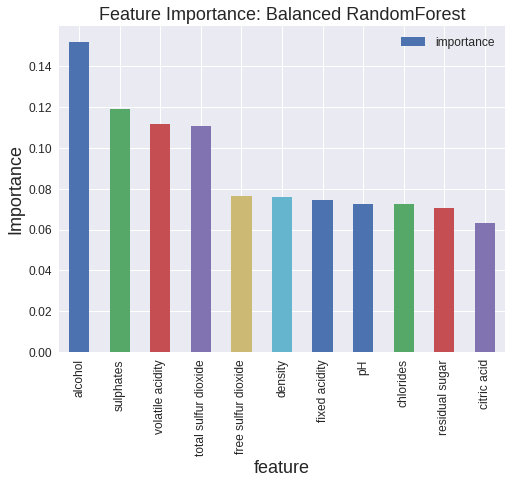

In [0]:
plt.rc('axes', titlesize=MEDIUM_SIZE)
fig, ax = plt.subplots(figsize=(8, 6))
fi_rdf_bal.plot.bar(x='feature', y='importance', ax=ax)
ax.set_title('Feature Importance: Balanced RandomForest')
ax.set_ylabel('Importance')

### Combined Classes 

At this point the drill is well established. Do one grid search to get the optimal number of max_features, then manually tune the number of estimators.

#### Grid Search

In [0]:
param_grid_rdf = {
    'n_estimators': [500, 750, 1000],
    'max_features': [2, 4, 6]
}

rdf_bin = RandomForestClassifier(random_state=42)
grid_rdf_bin = GridSearchCV(rdf_bin, param_grid_rdf, cv=5, refit=True, n_jobs=-1, verbose=1)
grid_rdf_bin.fit(X_train_scaled, y_train_bin)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [500, 750, 1000], 'max_features': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
grid_rdf_bin.best_params_

{'max_features': 2, 'n_estimators': 750}

In [0]:
y_train_bin_pred_rdf = grid_rdf_bin.predict(X_train_scaled)
y_test_bin_pred_rdf = grid_rdf_bin.predict(X_test_scaled)


reports("Combined RandomForest",
    X_train_scaled, X_test_scaled, 
    y_train_bin, y_train_bin_pred_rdf, 
    y_test_bin, y_test_bin_pred_rdf)

Combined RandomForest Train Accuracy Score: 1.0

Combined RandomForest Train Confusion Matrix
[[603   0]
 [  0 676]]

Combined RandomForest Train Classification Report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       603
        True       1.00      1.00      1.00       676

   micro avg       1.00      1.00      1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

-----------------------------------------------------

Combined RandomForest Test Accuracy Score: 0.790625

Combined RandomForest Test Confusion Matrix
[[108  33]
 [ 34 145]]

Combined RandomForest Test Classification Report
              precision    recall  f1-score   support

       False       0.76      0.77      0.76       141
        True       0.81      0.81      0.81       179

   micro avg       0.79      0.79      0.79       320
   macro avg       0.79      0.79      0.79       320
weighted

#### Manual Tuning

Manually search for hyperparameters than introduce some error into the training classification.

In [0]:
## Fit the model on the training sets
rdf_bin = RandomForestClassifier(random_state=42, max_features=2, n_estimators=10)
rdf_bin.fit(X_train_scaled, y_train_bin)

y_train_bin_pred_rdf = rdf_bin.predict(X_train_scaled)
y_test_bin_pred_rdf = rdf_bin.predict(X_test_scaled)

# limit to probability for class = 1
y_train_bin_pred_rdf_proba = rdf_bin.predict_proba(X_train_scaled)[:,1]
y_test_bin_pred_rdf_proba = rdf_bin.predict_proba(X_test_scaled)[:,1]

reports("Combined RandomForest",
    X_train_scaled, X_test_scaled, 
    y_train_bin, y_train_bin_pred_rdf, 
    y_test_bin, y_test_bin_pred_rdf)

Combined RandomForest Train Accuracy Score: 0.9937451133698202

Combined RandomForest Train Confusion Matrix
[[601   2]
 [  6 670]]

Combined RandomForest Train Classification Report
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       603
        True       1.00      0.99      0.99       676

   micro avg       0.99      0.99      0.99      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       0.99      0.99      0.99      1279

-----------------------------------------------------

Combined RandomForest Test Accuracy Score: 0.796875

Combined RandomForest Test Confusion Matrix
[[117  24]
 [ 41 138]]

Combined RandomForest Test Classification Report
              precision    recall  f1-score   support

       False       0.74      0.83      0.78       141
        True       0.85      0.77      0.81       179

   micro avg       0.80      0.80      0.80       320
   macro avg       0.80      0.80      0.80    

0.8715480011093943


Text(0.5,0,'False Positive Rate')

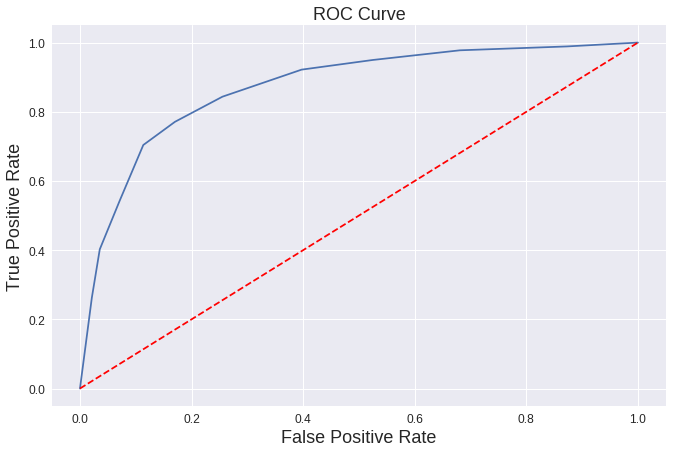

In [0]:
fpr, tpr, threshold = metrics.roc_curve(y_test_bin, y_test_bin_pred_rdf_proba)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(fpr, tpr)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [0]:
models['RDF']['combined'] = {
    'model': rdf_bin,
    'params': {'n_estimators':10, 'max_features':2},
    'accuracy': {
        'train': (y_train_bin == y_train_bin_pred_rdf).mean(),
        'test': (y_test_bin == y_test_bin_pred_rdf).mean()
    },
    'roc': roc_auc
}

#### Feature Importance

In [0]:
importances = rdf_bin.feature_importances_
fi_rdf_bin = pd.DataFrame(
    data={'importance': pd.Series(importances), 
          'feature': X.columns
         }
).sort_values('importance', ascending=False)
fi_rdf_bin

,feature,importance
10,alcohol,0.183632
9,sulphates,0.137612
1,volatile acidity,0.096690
7,density,0.094205
6,total sulfur dioxide,0.088545
0,fixed acidity,0.077845
4,chlorides,0.076441
8,pH,0.065166
2,citric acid,0.064673
5,free sulfur dioxide,0.059001


Text(0,0.5,'Importance')

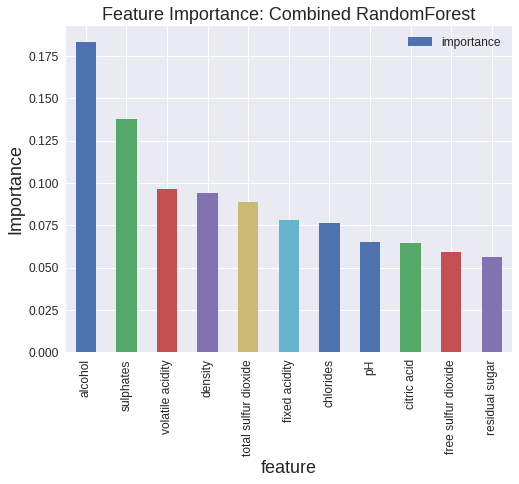

In [0]:
plt.rc('axes', titlesize=MEDIUM_SIZE)
fig, ax = plt.subplots(figsize=(8, 6))
fi_rdf_bin.plot.bar(x='feature', y='importance', ax=ax)
ax.set_title('Feature Importance: Combined RandomForest')
ax.set_ylabel('Importance')

# Model Comparison

In [0]:
for m in models:
    print(m)
    print('Unbalanced:', models[m]['unbalanced']['accuracy'])
    print('Balanced:', models[m]['balanced']['accuracy'])
    print('Combined:', models[m]['combined']['accuracy'])

SVM
Unbalanced: {'train': 0.5934323690383112, 'test': 0.565625}
Balanced: {'train': 0.5763760049474336, 'test': 0.53125}
Combined: {'train': 0.746677091477717, 'test': 0.728125}
ADA
Unbalanced: {'train': 0.5582486317435497, 'test': 0.528125}
Balanced: {'train': 0.5553494124922697, 'test': 0.565625}
Combined: {'train': 0.8076622361219703, 'test': 0.759375}
RDF
Unbalanced: {'train': 0.8889757623143081, 'test': 0.871875}
Balanced: {'train': 0.9981447124304267, 'test': 0.89375}
Combined: {'train': 0.9937451133698202, 'test': 0.796875}


The best model here is RandomForest on the unbalanced dataset